---
title: Euler-Maruayama Method for Stochastic Differential Equations
date: 2025-02-19 08:16:14
author: Dhilan Patel
---

In [135]:
import numpy as np 
import matplotlib.pyplot as plt

In this worksheet, you'll simulate a the geometric brownian motion using the Euler-Maruyama method. The Euler-Maruyama method is a numerical method for solving SDEs which is an extension of the Euler method for ordinary differential equations.


## EM method for SDEs

1. Define an SDE class for the SDE 
   $$dX_t = \alpha(X_t, t) dt + \beta(X_t, t) dW_t$$
    where $W_t$ is a Wiener process. Note that $\alpha$ and $\beta$ are functions of $X_t$ and $t$ and in python these should be defined as lambda functions.
2. Define two methods:
   - `EM_sample_paths`: This method should return a list of sample paths of the SDE using the Euler-Maruyama method.
   - `EM_endpoints`: This method should return the expected value of the SDE at a given time $T$.
  
   Both these methods should be have a parameter `wiener_increments` which is a list of random variables that are normally distributed with variance $dt$.
   If this is `None` then you should generate your own Wiener increments. If not, you should use the provided Wiener increments to generate the sample paths. This is needed for testing purposes.

**Warning:** 

When returning sample paths, you should return an array of length `N + 1` where `N` is the number of time steps. This is because the array should include the initial value of the SDE.

Similarly, when returning the expected value of the SDE at time $T$ start with the initial value of the SDE at time $0$.

If you use the wrong indices, your convergence tests might look way off.

In [136]:
class SDE:
  def __init__(self, alpha, beta):
    self.alpha = alpha
    self.beta = beta

  def EM_sample_path(self, x0, T, N, wiener_increments=None): # single sample path
    dt = T / N
    # wiener_increments are sampled random variables
    if wiener_increments is None:
      wiener_increments = np.random.normal(0, np.sqrt(dt), N) # takes std
    sample_path = np.zeros(N+1)
    sample_path[0] = x0
    for i in range(0, N):
      xi, dwi = sample_path[i], wiener_increments[i]
      ti = i * dt
      sample_path[i+1] = xi + self.alpha(xi, ti) * dt + self.beta(xi, ti) * dwi
    return sample_path # deterministic

  def EM_endpoint(self, x0, T, N, wiener_increments=None):
    # really just the endpoint of a single sample path
    return self.EM_sample_path(x0, T, N, wiener_increments)[-1]
  

## Brownian motion 

Define a class `BrownianMotion` as a subclass of the SDE class which models the geometric Brownian motion defined by the SDE
$$dX_t = \mu X_t dt + \sigma X_t dW_t$$
where $\mu$ and $\sigma$ are constants. 


This class should have the following methods:
- `exact_sample_paths`: This method should return a list of sample paths of the geometric Brownian motion.
- `exact_endpoints`: This method should return the expected value of the geometric Brownian motion at a given time $T$.

In [137]:

class GeometricBrownianMotion(SDE):
  def __init__(self, mu, sigma):
    self.mu = mu
    self.sigma = sigma
    alpha = lambda x, t: self.mu * x
    beta = lambda x, t: self.sigma * x
    super().__init__(alpha, beta)

  def exact_sample_path(self, x0, T, N, wiener_increments=None):
    dt = T / N
    if wiener_increments is None:
      wiener_increments = np.random.normal(0, np.sqrt(dt), N)
    exponent = lambda i: (self.mu - self.sigma ** 2 / 2) * i * dt + self.sigma * np.sum(wiener_increments[:i+1])
    sample_path = [x0 * np.exp(exponent(i)) for i in range(N+1)]
    return sample_path

  def exact_endpoint(self, x0, T, N, wiener_increments=None):
    if wiener_increments is None:
      W_T = np.random.normal(0, np.sqrt(T))
    else:
      W_T = np.sum(wiener_increments)
    return x0 * np.exp((self.mu - self.sigma ** 2 / 2) * T + self.sigma * W_T)
    

## Test the exact solution for the geometric Brownian motion

For the parameters defined below, 

1. Generate 1000 sample paths of the exact solution of the geometric Brownian motion.
2. Plot the first 10 sample paths - use `linewidth=0.5` to make the paths clearer.
3. Plot the average of all of the 1000 sample paths.

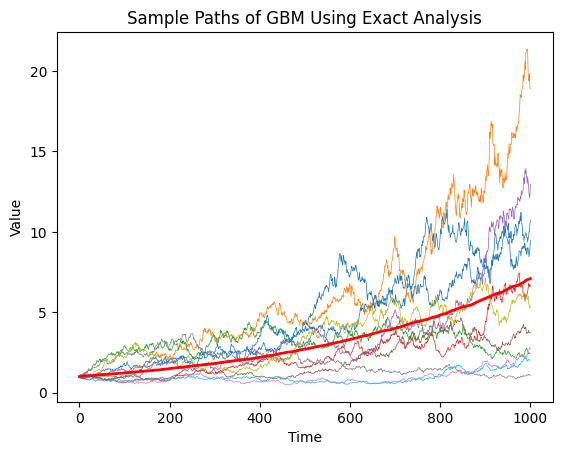

In [138]:
T = 1 # Time horizon
N = 1000 # Number of subdivisions of the time interval [0, T]
mu = 2 
sigma = 1
x0 = 1 # Initial value of the process

gbm = GeometricBrownianMotion(mu, sigma)

sample_paths = [gbm.EM_sample_path(x0, T, N) for _ in range(1000)]
[plt.plot(sample_path, linewidth=0.5) for sample_path in sample_paths[:11]]
average_path = np.mean(sample_paths, axis=0) # element-wise mean
plt.plot(average_path, color='red', linewidth=2)
plt.title('Sample Paths of GBM Using Exact Analysis')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()


## Test the EM method for the geometric Brownian motion

For the parameters defined below, 

1. Generate 1000 sample paths of geometric Brownian motion using the Euler-Maruyama method.
2. Plot the first 10 sample paths - use `linewidth=0.5` to make the paths clearer.
3. Plot the average of the 1000 sample paths.

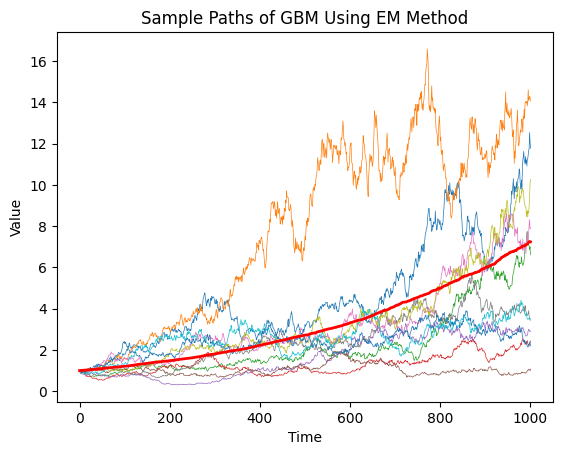

In [139]:
T = 1 # Time horizon
N = 1000 # Number of subdivisions of the time interval [0, T]
mu = 2 
sigma = 1
x0 = 1 # Initial value of the process

gbm = GeometricBrownianMotion(mu, sigma)

sample_paths = [gbm.EM_sample_path(x0, T, N) for _ in range(1000)]
[plt.plot(sample_path, linewidth=0.5) for sample_path in sample_paths[:11]]
average_path = np.mean(sample_paths, axis=0) # element-wise mean
plt.plot(average_path, color='red', linewidth=2)
plt.title('Sample Paths of GBM Using EM Method')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()


## Convergence analysis of the EM method

Instead of having a fixed time step, we will now vary the time step and see how well the Euler-Maruyama method converges to the exact solution.

For each `dt` given below,

1. Simulate 1000 sample paths of the geometric Brownian motion using the Euler-Maruyama method. This time we only need the endpoints i.e. $X(T)$.
2. Calculate the endpoint weak error given by 
    $$ 
    \text{weak error} = \left| \mathbb{E}[X(T)] - \mathbb{E} [X_i(T)] \right|
    $$
    where $X_i(1)$ is the endpoint of the $i$-th sample path.
3. Calculate the endpoint strong error given by 
    $$ 
    \text{strong error} = \mathbb{E}|(X(T) - X_i(T)|
    $$
    where $X_i(1)$ is the endpoint of the $i$-th sample path.
4. Plot the weak and strong errors as a function of the time step `dt` in the same plot. Use a log-log plot.
5. Using linear regression, find constants such that
    $$ 
    \text{weak error} \approx c_1 \text{dt}^{k_1}
    $$
    and 
    $$ 
    \text{strong error} \approx c_2 \text{dt}^{k_2}.
    $$
6. You should get different values of $k_1$ and $k_2$. Explain your observations.



Weak Error: c1 = 12.513342547224267, k1 = 1.0684408651427908
Strong Error: c2 = 5.518874969863891, k2 = 0.5562668623651079


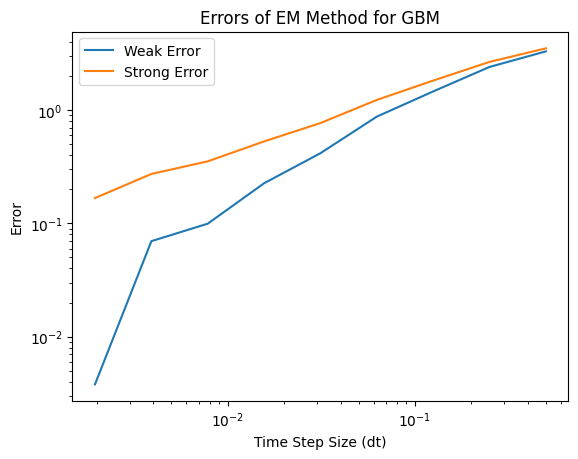

In [148]:
T = 1 
num_steps = [2**i for i in range(1, 10)] # Number of time steps
dt = [T/N for N in num_steps] # Time step sizes
mu = 2 
sigma = 1
x0 = 1 
num_paths = 1000

gbm = GeometricBrownianMotion(mu, sigma)

em_endpoints = np.zeros((len(num_steps), num_paths))
exact_endpoints = np.zeros((len(num_steps), num_paths))

for i, N in enumerate(num_steps):
    for j in range(num_paths):
        # sample path strong error: must use the same wiener increments for em and exact
        # weak error: averaging em and exact endpoints separately so it doesn't matter
        dW = np.random.normal(0, np.sqrt(dt[i]), N)
        em_endpoints[i, j] = gbm.EM_endpoint(x0, T, N, wiener_increments=dW)
        exact_endpoints[i, j] = gbm.exact_endpoint(x0, T, N, wiener_increments=dW)

weak_error = np.abs(np.mean(exact_endpoints, axis=1) - np.mean(em_endpoints, axis=1))
strong_error = np.mean(np.abs(exact_endpoints - em_endpoints), axis=1)

reg_weak = np.polyfit(np.log(dt), np.log(weak_error), 1)
reg_strong = np.polyfit(np.log(dt), np.log(strong_error), 1)

# log(error) = log(c1) + k1 * log(dt)
c1, k1 = np.exp(reg_weak[1]), reg_weak[0]
c2, k2 = np.exp(reg_strong[1]), reg_strong[0]

print(f'Weak Error: c1 = {c1}, k1 = {k1}')
print(f'Strong Error: c2 = {c2}, k2 = {k2}')


plt.plot(dt, weak_error, label='Weak Error')
plt.plot(dt, strong_error, label='Strong Error')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Time Step Size (dt)')
plt.ylabel('Error')
plt.title('Errors of EM Method for GBM')
plt.legend()
plt.show()



It makes sense that the strong error has a lower order of convergence than weak error, because it has additional constrains imposed on its definition of convergence. Weak convergence has a higher k-value, which makes the upper bound $c_1 \Delta t^{k_1}$ smaller, and the apparent error closer to 0.